<a href="https://colab.research.google.com/github/Suriyaskrs/Sugarcane_Pest_detection/blob/main/Agrithon_2_0_Insect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

customized yolo model

# **Installing Required libraries**

In [ ]:
!pip install albumentations opencv-python tqdm
!pip install -q  opencv-python-headless
!pip install ultralytics pyyaml
!pip install pytorch-tabnet scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12


# Unzipping the Annotated dataset

In [ ]:
!unzip /content/Round2_Insect.zip

Archive:  /content/Round2_Insect.zip
   creating: Round2_Insect/
  inflating: Round2_Insect/data.yaml  
   creating: Round2_Insect/images/
  inflating: Round2_Insect/images/lv3_t12_1.jpg  
  inflating: Round2_Insect/images/lv3_t12_10.jpg  
  inflating: Round2_Insect/images/lv3_t12_100.jpg  
  inflating: Round2_Insect/images/lv3_t12_1000.jpg  
  inflating: Round2_Insect/images/lv3_t12_1001.jpg  
  inflating: Round2_Insect/images/lv3_t12_1002.jpg  
  inflating: Round2_Insect/images/lv3_t12_1003.jpg  
  inflating: Round2_Insect/images/lv3_t12_1004.jpg  
  inflating: Round2_Insect/images/lv3_t12_1005.jpg  
  inflating: Round2_Insect/images/lv3_t12_1006.jpg  
  inflating: Round2_Insect/images/lv3_t12_1007.jpg  
  inflating: Round2_Insect/images/lv3_t12_1008.jpg  
  inflating: Round2_Insect/images/lv3_t12_1009.jpg  
  inflating: Round2_Insect/images/lv3_t12_101.jpg  
  inflating: Round2_Insect/images/lv3_t12_1010.jpg  
  inflating: Round2_Insect/images/lv3_t12_1011.jpg  
  inflating: Round2_

# **Data Augmentation Pipeline**

In [ ]:
import os
import cv2
import numpy as np
import random
import albumentations as A

# ================== CONFIG ===================
BASE_PATH = "/content/Round2_Insect"
IMAGE_DIR = os.path.join(BASE_PATH, "images")
LABEL_DIR = os.path.join(BASE_PATH, "labels")
AUGS_PER_IMAGE = 8  # exactly 10 augmentations per original

# Define augmentations (no resizing, blur, erasing, or distortion)
bbox_params = A.BboxParams(format='yolo', min_visibility=0.1, label_fields=['category_ids'])
augmentation_options = {
    "flip": A.HorizontalFlip(p=1.0),
    "rotate": A.Rotate(limit=20, p=1.0, border_mode=cv2.BORDER_CONSTANT),
    "color_jitter": A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02, p=1.0),
    "contrast": A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.2, p=1.0),
    "hue_shift": A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=1.0),
    "clahe": A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    "rgb_shift": A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=1.0),
    "channel_shuffle": A.ChannelShuffle(p=1.0)

    # ✅ Added 2 simple techniques
   # "sharpness": A.Sharpen(alpha=(0.1, 0.3), lightness=(0.9, 1.1), p=1.0),
    #"gamma": A.RandomGamma(gamma_limit=(80, 120), p=1.0)
}
aug_names = list(augmentation_options.keys())

# ================== AUGMENT ===================
print("\n🚀 Starting augmentation pipeline...")
all_images = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.jpg')])
num_existing = len(all_images)
aug_count = 0

for filename in all_images:
    base_name = os.path.splitext(filename)[0]
    image_path = os.path.join(IMAGE_DIR, filename)
    label_path = os.path.join(LABEL_DIR, base_name + '.txt')

    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    bboxes, category_ids = [], []
    if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    category_ids.append(int(float(parts[0])))
                    bboxes.append([float(p) for p in parts[1:]])
    if not bboxes:
        continue

    for j in range(AUGS_PER_IMAGE):
        aug_name = random.choice(aug_names)
        aug_func = A.Compose([augmentation_options[aug_name]], bbox_params=bbox_params)

        try:
            transformed = aug_func(image=image, bboxes=bboxes, category_ids=category_ids)
            if transformed['bboxes']:
                new_filename = f"{base_name}_aug_{j+1}_{aug_name}.jpg"
                new_labelname = os.path.splitext(new_filename)[0] + '.txt'
                cv2.imwrite(os.path.join(IMAGE_DIR, new_filename),
                            cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR))
                with open(os.path.join(LABEL_DIR, new_labelname), 'w') as f:
                    for b, c_id in zip(transformed['bboxes'], transformed['category_ids']):
                        f.write(f"{c_id} {' '.join([f'{c:.6f}' for c in b])}\n")
                aug_count += 1
        except Exception:
            continue

print(f"✅ Augmentation complete! Added {aug_count} images.")
print(f"Total images in folder now: {len(os.listdir(IMAGE_DIR))}")


# **Data Spliting**

In [ ]:
import os
import random
import shutil

random.seed(42)

# === Configuration ===
BASE_PATH = "/content/Round2_Insect"
IMAGE_PATH = os.path.join(BASE_PATH, "images")   # original images directory
LABEL_PATH = os.path.join(BASE_PATH, "labels")   # original labels directory

DEST_IMAGE_PATH = os.path.join(BASE_PATH, "images")
DEST_LABEL_PATH = os.path.join(BASE_PATH, "labels")

SPLITS = {
    "train": 0.7,
    "val": 0.2,
    "test": 0.1
}

# === Make split directories ===
for split in SPLITS:
    os.makedirs(os.path.join(DEST_IMAGE_PATH, split), exist_ok=True)
    os.makedirs(os.path.join(DEST_LABEL_PATH, split), exist_ok=True)

# === Collect and shuffle filenames ===
image_files = [f for f in os.listdir(IMAGE_PATH) if f.endswith(".jpg")]
random.shuffle(image_files)

total = len(image_files)
train_end = int(SPLITS["train"] * total)
val_end = train_end + int(SPLITS["val"] * total)

split_map = {
    "train": image_files[:train_end],
    "val": image_files[train_end:val_end],
    "test": image_files[val_end:]
}

for split, files in split_map.items():
    for file in files:
        # Image and label filenames
        img_src = os.path.join(IMAGE_PATH, file)
        lbl_src = os.path.join(LABEL_PATH, file.replace(".jpg", ".txt"))

        img_dst = os.path.join(DEST_IMAGE_PATH, split, file)
        lbl_dst = os.path.join(DEST_LABEL_PATH, split, file.replace(".jpg", ".txt"))

        # Copy if label exists
        if os.path.exists(lbl_src):
            shutil.copy(img_src, img_dst)
            shutil.copy(lbl_src, lbl_dst)
        else:
            print(f"[Warning] Label missing for {file}, skipping.")


In [ ]:
import os
from glob import glob

# Base paths
BASE_PATH = "/content/Round2_Insect"
SPLITS = ["train", "val", "test"]

for split in SPLITS:
    image_dir = os.path.join(BASE_PATH, "images", split)
    image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))

    # Write to txt file
    txt_path = os.path.join(BASE_PATH, f"{split}.txt")
    with open(txt_path, "w") as f:
        for path in image_paths:
            f.write(f"{path}\n")

    print(f"✅ {split}.txt written with {len(image_paths)} entries.")


In [ ]:
import yaml

data = {
    'path': '/content/Round2_Insect',
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': {0: 'insect'}
}

with open('/content/Round2_Insect/data.yaml', 'w') as file:
    yaml.dump(data, file, sort_keys=False)


# **Yolov8s Model Training**

In [ ]:
# Step 1: Install Ultralytics
# Step 2: Import and check CUDA
import torch
from ultralytics import YOLO

print("✅ CUDA available:", torch.cuda.is_available())
print("🔍 CUDA device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# Step 3: Load model and set training parameters

# Step 4: Train the model

from ultralytics import YOLO

# Load the YOLOv8s model with pretrained weights
model = YOLO("yolov8s.pt")

# Train the model with slightly optimized settings
model.train(
    data="/content/Round2_Insect/data.yaml",  # Path to your dataset YAML
    epochs=25,                      # Slightly more epochs for better learning
    imgsz=1024,                      # Higher image size than 416 for more detail
    batch=8,                        # Conservative batch size for 15GB GPU
    name="yolov8s_larva_v2",      # Custom experiment name
    device=0,                       # Use GPU 0
    workers=4,                      # Number of data loading threads
    patience=10,                    # Early stopping if no improvement
    lr0=0.001,                      # Initial learning rate (slightly tuned)
    weight_decay=0.0005,            # Regularization
    warmup_epochs=2,                # Gradual warmup to stabilize training
    close_mosaic=5,                 # Disable mosaic augmentation in final 5 epochs
    fliplr=0.5,                     # Use horizontal flip augmentation
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,  # Light color augmentations
    cache=True                      # Speed up training by caching images
)




✅ CUDA available: True
🔍 CUDA device: Tesla T4
Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=5, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Round2_Insect/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8s_larva_v24, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patie

train: Scanning /content/Round2_Insect/labels/train.cache... 9450 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9450/9450 [00:00<?, ?it/s]


WARNING ⚠️ train: 41.5GB RAM required to cache images with 50% safety margin but only 8.3/12.7GB available, not caching images
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 609.1±82.2 MB/s, size: 165.3 KB)


val: Scanning /content/Round2_Insect/labels/val.cache... 2700 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2700/2700 [00:00<?, ?it/s]


WARNING ⚠️ val: 11.9GB RAM required to cache images with 50% safety margin but only 8.1/12.7GB available, not caching images
Plotting labels to runs/detect/yolov8s_larva_v24/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8s_larva_v24
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      4.73G      1.236      1.282      1.153          2       1024: 100%|██████████| 1182/1182 [07:14<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:52<00:00,  3.23it/s]


                   all       2700       2704       0.95      0.889      0.937      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25      5.66G      1.181      0.666      1.131          0       1024: 100%|██████████| 1182/1182 [07:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:50<00:00,  3.33it/s]


                   all       2700       2704       0.96      0.937      0.968      0.681

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      5.69G      1.115     0.5928      1.119          2       1024: 100%|██████████| 1182/1182 [07:06<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:49<00:00,  3.38it/s]

                   all       2700       2704      0.988      0.983      0.991      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      5.72G      1.064     0.5449      1.092          5       1024: 100%|██████████| 1182/1182 [07:06<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:51<00:00,  3.31it/s]

                   all       2700       2704      0.995      0.991      0.995       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25      5.74G      1.015     0.5073      1.076          3       1024: 100%|██████████| 1182/1182 [07:09<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:49<00:00,  3.39it/s]

                   all       2700       2704      0.993      0.994      0.992      0.754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      5.76G     0.9767     0.4805      1.057          3       1024: 100%|██████████| 1182/1182 [07:06<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:49<00:00,  3.40it/s]

                   all       2700       2704      0.982      0.983      0.989      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      5.76G     0.9506     0.4598      1.044          1       1024: 100%|██████████| 1182/1182 [07:03<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:51<00:00,  3.25it/s]

                   all       2700       2704      0.995      0.992      0.994      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      5.76G     0.9345     0.4497      1.036          1       1024: 100%|██████████| 1182/1182 [07:04<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:50<00:00,  3.32it/s]

                   all       2700       2704      0.995      0.995      0.995      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      5.76G     0.9085     0.4319      1.028          1       1024: 100%|██████████| 1182/1182 [07:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:50<00:00,  3.32it/s]

                   all       2700       2704      0.991      0.992      0.994      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      5.76G     0.8969     0.4255      1.017          1       1024: 100%|██████████| 1182/1182 [07:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:50<00:00,  3.36it/s]

                   all       2700       2704      0.995      0.991      0.995      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      5.76G     0.8684     0.4153      1.009          3       1024: 100%|██████████| 1182/1182 [07:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:48<00:00,  3.47it/s]

                   all       2700       2704      0.994      0.993      0.994        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      5.76G     0.8635     0.4043      1.003          3       1024: 100%|██████████| 1182/1182 [07:11<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:48<00:00,  3.45it/s]

                   all       2700       2704      0.996      0.997      0.995      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      5.76G     0.8424     0.3942     0.9976          4       1024: 100%|██████████| 1182/1182 [07:03<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:50<00:00,  3.33it/s]

                   all       2700       2704      0.995      0.994      0.995      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      5.76G      0.825     0.3821     0.9802          3       1024: 100%|██████████| 1182/1182 [07:03<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:50<00:00,  3.33it/s]

                   all       2700       2704      0.997      0.993      0.995      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      5.76G     0.8112     0.3728      0.976          1       1024: 100%|██████████| 1182/1182 [07:06<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:52<00:00,  3.24it/s]

                   all       2700       2704      0.999      0.998      0.995      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25      5.76G     0.7939     0.3627     0.9712          4       1024: 100%|██████████| 1182/1182 [07:06<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:49<00:00,  3.40it/s]

                   all       2700       2704      0.997      0.996      0.995      0.844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      5.76G     0.7858     0.3584     0.9706          3       1024: 100%|██████████| 1182/1182 [07:08<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:49<00:00,  3.39it/s]

                   all       2700       2704      0.997      0.997      0.995      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      5.76G      0.774     0.3492     0.9718          1       1024: 100%|██████████| 1182/1182 [07:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:50<00:00,  3.38it/s]

                   all       2700       2704          1      0.998      0.995      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      5.76G     0.7546     0.3427     0.9563          4       1024: 100%|██████████| 1182/1182 [07:11<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:50<00:00,  3.38it/s]

                   all       2700       2704      0.999      0.998      0.995      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      5.76G     0.7371     0.3284     0.9495          2       1024: 100%|██████████| 1182/1182 [07:09<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:50<00:00,  3.35it/s]

                   all       2700       2704      0.999      0.999      0.995       0.86


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      5.76G     0.6957     0.2945     0.9294          2       1024: 100%|██████████| 1182/1182 [06:55<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:50<00:00,  3.34it/s]

                   all       2700       2704          1      0.999      0.995      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      5.76G     0.6805     0.2857      0.921          2       1024: 100%|██████████| 1182/1182 [06:48<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:50<00:00,  3.38it/s]

                   all       2700       2704          1      0.999      0.995      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      5.77G     0.6664     0.2774     0.9145          2       1024: 100%|██████████| 1182/1182 [06:53<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:49<00:00,  3.41it/s]

                   all       2700       2704          1      0.999      0.995      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      5.77G      0.651     0.2693     0.9053          2       1024: 100%|██████████| 1182/1182 [06:59<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:51<00:00,  3.29it/s]

                   all       2700       2704          1      0.999      0.995      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      5.77G     0.6387     0.2637     0.9026          2       1024: 100%|██████████| 1182/1182 [06:58<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:47<00:00,  3.52it/s]

                   all       2700       2704          1      0.999      0.995      0.881



25 epochs completed in 3.306 hours.
Optimizer stripped from runs/detect/yolov8s_larva_v24/weights/last.pt, 22.6MB
Optimizer stripped from runs/detect/yolov8s_larva_v24/weights/best.pt, 22.6MB

Validating runs/detect/yolov8s_larva_v24/weights/best.pt...
Ultralytics 8.3.176 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 169/169 [00:54<00:00,  3.08it/s]


                   all       2700       2704          1      0.999      0.995      0.882
Speed: 0.6ms preprocess, 10.9ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/yolov8s_larva_v24


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x786078cfdd50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
# Step 1: Install Ultralytics
# pip install ultralytics

# Step 2: Import and check CUDA
import torch
from ultralytics import YOLO

print("✅ CUDA available:", torch.cuda.is_available())
print("🔍 CUDA device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

# Step 3: Load YOLOv8s model (pretrained)
model = YOLO("yolov8s.pt")

# Step 4: Hyperparameter tuning
model.tune(
    data="/content/Round2_Insect/data.yaml",  # Path to dataset YAML
    epochs=5,                      # Fewer epochs for tuning stage
    batch=8,                        # Start batch size (can be adjusted by tuner)
    optimizer="SGD",                 # Try different optimizers (SGD/Adam/AdamW)
    device=0,                        # GPU 0
    workers=4,                       # Data loader workers
    plots=True,                      # Save plots for results
    iterations=10,                   # Number of tuning iterations (try more for better search)
    patience=5,                      # Early stopping patience during tuning
    save=True,                       # Save best hyperparameters
    cache=True                       # Cache images for faster tuning
)

# Step 5: Once best hyperparameters are found, train final model
best_params = model.best_hyperparameters
print("\n✅ Best Hyperparameters Found:", best_params)

model.train(
    data="/content/Round2_Insect/data.yaml",
    epochs=15,
    batch=best_params.get("batch", 16),
    lr0=best_params.get("lr0", 0.001),
    optimizer=best_params.get("optimizer", "SGD"),
    momentum=best_params.get("momentum", 0.937),
    weight_decay=best_params.get("weight_decay", 0.0005),
    hsv_h=best_params.get("hsv_h", 0.015),
    hsv_s=best_params.get("hsv_s", 0.7),
    hsv_v=best_params.get("hsv_v", 0.4),
    fliplr=best_params.get("fliplr", 0.5),
    device=0,
    workers=4,
    patience=10,
    close_mosaic=5,
    cache=True
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ CUDA available: True
🔍 CUDA device: Tesla T4


Tuner: Initialized Tuner instance with 'tune_dir=runs/detect/tune'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/10 with hyperparameters: {'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'box': 7.5, 'cls': 0.5, 'dfl': 1.5, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'bgr': 0.0, 'mosaic': 1.0, 'mixup': 0.0, 'cutmix': 0.0, 'copy_paste': 0.0}
Saved runs/detect/tune/tune_scatter_plots.png
Saved runs/detect/tune/tune_fitness.png

Tuner: 1/10 iterations complete ✅ (169.18s)
Tuner: Results saved to runs/detect/tune
Tuner: Best fitness=0.77261 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.9994, 'metrics/recall(B)': 1.0, 'metrics/mAP50(B)': 0.995, 'metrics/mAP50-95(B)': 0.74791, 'val/box_loss': 0.94741, 'val/cls_

AttributeError: 'DetectionModel' object has no attribute 'best_hyperparameters'

In [ ]:
results = model.predict(source="/content/Round2_Insect/images/test", conf=0.4, iou=0.5,save=True)


WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1350 /content/Round2_Insect/images/test/lv3_t12_1002.jpg: 416x416 1 insect, 15.3ms
image 2/1350 /content/Round2_Insect/images/test/lv3_t12_1003_aug_3_rgb_shift.jpg: 416x416 1 insect, 14.9ms
image 3/1350 /content/Round2_Insect/images/test/lv3_t12_1003_aug_7_rotate.jpg: 416x416 1 insect, 15.0ms
image 4/1350 /content/Round2_Insect/images/test/lv3_t12_1004_aug_6_contrast.jpg: 416x416 1 insect, 15.1ms
image 5/1350 /content/Round2_Insect/images/test/

KeyboardInterrupt: 

In [ ]:
results = model.val()  # evaluate on test.txt
print(results)


Ultralytics 8.3.172 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 138.6±194.8 MB/s, size: 26.0 KB)


val: Scanning /content/Insect_Dataset/labels/val.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.1GB RAM): 100%|██████████| 100/100 [00:00<00:00, 299.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  4.60it/s]


                   all        100        100      0.999          1      0.995      0.892
Speed: 5.3ms preprocess, 11.6ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/detect/yolov8s_insect_v224
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ce54f4af8d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.03

In [ ]:
results = model.val(split='test')  # evaluate on test.txt
print(results)

Ultralytics 8.3.172 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 731.6±467.8 MB/s, size: 23.5 KB)


val: Scanning /content/Insect_Dataset/labels/test... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 1722.72it/s]

val: New cache created: /content/Insect_Dataset/labels/test.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.1GB RAM): 100%|██████████| 50/50 [00:00<00:00, 491.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:01<00:00,  4.38it/s]


                   all         50         50      0.999          1      0.995      0.907
Speed: 4.9ms preprocess, 12.9ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/detect/yolov8s_insect_v223
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ce5671febd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.03

# **Synthetic Dataset Creation**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

# Step 1: Load your 500-row dataset
df = pd.read_csv("dead_heart_tabnet.csv")

# Separate features and target
X = df.drop("Target", axis=1)
y = df["Target"]

# Step 2: Train RandomForest to get feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_
feature_weights = dict(zip(X.columns, importances))

# Normalize the importance scores (sum to 1)
total_importance = sum(importances)
normalized_weights = {k: v / total_importance for k, v in feature_weights.items()}

# Step 3: Generate 2000 synthetic samples
synthetic_rows = []
for _ in range(2000):
    # Choose a real row to mutate
    row = df.sample(1).drop("Target", axis=1).iloc[0].copy()

    # Modify features based on importance weight
    for feature in row.index:
        if np.random.rand() < normalized_weights[feature]:  # Higher weight = more likely to change
            row[feature] = 1 - row[feature]  # Flip 0↔1

    # Predict the disease label using the trained model
    label = rf.predict([row])[0]
    row["Target"] = label

    synthetic_rows.append(row)

# Step 4: Combine original + synthetic
df_synthetic = pd.DataFrame(synthetic_rows)
df_final = pd.concat([df, df_synthetic], ignore_index=True)
df_final = shuffle(df_final, random_state=42).reset_index(drop=True)

# Step 5: Save the final dataset
df_final.to_csv("synthetic_dead_heart_dataset.csv", index=False)

print("✅ Generated and saved dataset as 'synthetic_dead_heart_dataset.csv'")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local

✅ Generated and saved dataset as 'synthetic_dead_heart_dataset.csv'


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the 2500-row dataset
df = pd.read_csv("synthetic_insect_dataset_2500.csv")


# Encode target
le = LabelEncoder()
df["insect_present"] = le.fit_transform(df["insect_present"])

# Features and Target
X = df.drop("insect_present", axis=1).values
y = df["insect_present"].values

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# **Tabnet Model Training**

In [ ]:
clf = TabNetClassifier(seed=42, verbose=1)

clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_name=["valid"],
    eval_metric=["accuracy"],
    max_epochs=100,
    batch_size=256,
    virtual_batch_size=128
)
import joblib
joblib.dump(clf, "tabnet_insect_classifier.pkl")


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.80662 | valid_accuracy: 0.604   |  0:00:00s
epoch 1  | loss: 0.57692 | valid_accuracy: 0.628   |  0:00:00s
epoch 2  | loss: 0.48942 | valid_accuracy: 0.634   |  0:00:00s
epoch 3  | loss: 0.44137 | valid_accuracy: 0.634   |  0:00:01s
epoch 4  | loss: 0.39597 | valid_accuracy: 0.634   |  0:00:01s
epoch 5  | loss: 0.34112 | valid_accuracy: 0.686   |  0:00:01s
epoch 6  | loss: 0.32087 | valid_accuracy: 0.754   |  0:00:01s
epoch 7  | loss: 0.30593 | valid_accuracy: 0.826   |  0:00:01s
epoch 8  | loss: 0.29134 | valid_accuracy: 0.844   |  0:00:02s
epoch 9  | loss: 0.27484 | valid_accuracy: 0.86    |  0:00:02s
epoch 10 | loss: 0.29409 | valid_accuracy: 0.876   |  0:00:02s
epoch 11 | loss: 0.28437 | valid_accuracy: 0.872   |  0:00:02s
epoch 12 | loss: 0.2679  | valid_accuracy: 0.876   |  0:00:03s
epoch 13 | loss: 0.24138 | valid_accuracy: 0.864   |  0:00:03s
epoch 14 | loss: 0.22469 | valid_accuracy: 0.894   |  0:00:03s
epoch 15 | loss: 0.20217 | valid_accuracy: 0.888   |  0

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


['tabnet_insect_classifier.pkl']

In [ ]:
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.97
Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       184
           1       0.97      0.98      0.98       316

    accuracy                           0.97       500
   macro avg       0.97      0.96      0.97       500
weighted avg       0.97      0.97      0.97       500



# **Multimodal Pipeline**

In [ ]:
import torch
from ultralytics import YOLO
import numpy as np
from pytorch_tabnet.tab_model import TabNetClassifier
import joblib
import cv2
import matplotlib.pyplot as plt

# ========== Step 1: Load Models ==========

yolo_model = YOLO("/content/best_insect.pt")  # path to your YOLOv8 model
tabnet_model = joblib.load("/content/tabnet_insect_classifier.pkl")  # path to your TabNet model

# ========== Step 2: YOLO Prediction with Bounding Box ==========

def predict_image(image_path, save_annotated_path="/content/predicted.jpg"):
    results = yolo_model.predict(source=image_path, conf=0.4, save=False, save_txt=False, save_crop=False, verbose=False)

    # Save image with bounding box
    annotated_img = results[0].plot()  # returns numpy image with bounding boxes
    cv2.imwrite(save_annotated_path, annotated_img)

    # Extract class predictions
    predicted_classes = results[0].boxes.cls.cpu().numpy() if results[0].boxes is not None else []
    class_names = [yolo_model.names[int(i)] for i in predicted_classes]

    return class_names, save_annotated_path

# ========== Step 3: TabNet Prediction ==========

def predict_tabnet(answer_vector):
    preds = tabnet_model.predict(answer_vector)
    return preds[0]

# ========== Step 4: Weighted Decision Logic ==========

def combine_predictions(yolo_preds, tabnet_pred, yolo_weight=0.6, tabnet_weight=0.4):
    if not yolo_preds:
        return f"Final Decision: Based on TabNet prediction ➜ {tabnet_pred}"
    if tabnet_pred in yolo_preds:
        return f"Final Decision: Both models agree ➜ {tabnet_pred}"
    return f"Final Decision: YOLO prediction ➜ {yolo_preds[0]} (TabNet suggested: {tabnet_pred})"

# ========== Step 5: Complete Pipeline ==========

def full_prediction_pipeline(image_path, binary_answers_30):
    print("📷 Running YOLO prediction...")
    yolo_result, annotated_img_path = predict_image(image_path)

    print(f"🔍 YOLO Detected: {yolo_result if yolo_result else 'No insect detected'}")

    # Display the image with bounding box
    img = cv2.imread(annotated_img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title("YOLOv8 Prediction with Bounding Boxes")
    plt.axis('off')
    plt.show()

    print("🧠 Waiting for answers to 30 questions...")
    answers = np.array(binary_answers_30).reshape(1, -1)

    tabnet_result = predict_tabnet(answers)
    print(f"🧠 TabNet Predicted: {tabnet_result}")

    final_result = combine_predictions(yolo_result, tabnet_result)
    print("✅", final_result)
    return final_result


📷 Running YOLO prediction...
🔍 YOLO Detected: ['insect']


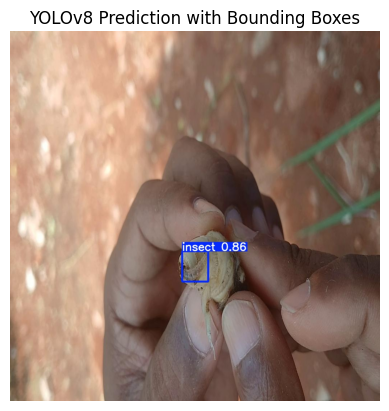

🧠 Waiting for answers to 30 questions...
🧠 TabNet Predicted: 1
✅ Final Decision: YOLO prediction ➜ insect (TabNet suggested: 1)


'Final Decision: YOLO prediction ➜ insect (TabNet suggested: 1)'

In [ ]:
# Path to the user-provided image
image_path = "/content/lv3_t12_258.jpg"

# Simulate user-provided 39 binary answers (you can replace with actual input)
binary_answers_39 = [1,1,1,1,1,1,1,1,0,1,0,0,1,1,1,0,1,0,1,1,1,1,0,0,0,1,0,1,1,0,1,0,1,1,0,1,0]
#
# Run the pipeline
full_prediction_pipeline(image_path, binary_answers_39)
